In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import sys
import math
np.set_printoptions(threshold=sys.maxsize)

from optim import Model, training_loop
from generateData import generateData
from helper import computeVisibility, pulse, matchFilt
from shape import carving

In [2]:
def generateDataFast(las_x, las_y, det_x, det_y, visibility, numBins, plotData, plotSetup, usePulse=True, pctNoise=0, jitter=0, pulseWidth=None, t=None):  
    ############
    # INPUTS: 
    #   visibility = numPixels x numSpots
    # OUTPUTS:
    #   hists = numPixels x numSpots x numBins tensor
    #   observations = numPixels x numBins tensor
    ############
    # constant variables
    c = 3E8   
    numSpots = len(las_x)
    numPixels = len(det_x)
    
    det_x = np.tile(np.reshape(det_x, (numPixels, 1)), (1, numSpots))
    det_y = np.tile(np.reshape(det_y, (numPixels, 1)), (1, numSpots))

    las_x = np.tile(np.reshape(las_x, (1, numSpots)), (numPixels, 1))
    las_y = np.tile(np.reshape(las_y, (1, numSpots)), (numPixels, 1))
    
    # compute tof
    pathLen = (las_x**2 + las_y**2)**0.5 + ((las_x-det_x)**2 + (las_y-det_y)**2)**0.5 + (det_x**2+det_y**2)**0.5
    tof = np.reshape(pathLen / c, (numPixels, numSpots, 1))
    
    # create array of pulses
    t, a = pulse(0, numBins)
    a = np.reshape(a, (1, 1, numBins))
    pulseArr = np.tile(a, (numPixels, numSpots, 1))
    
    # shift pulses by t0
    pulses_fft = np.fft.fft(pulseArr)
    f = np.reshape(np.fft.fftfreq(len(t), 100E-12), (1, 1, numBins))
    f = np.tile(f, (numPixels, numSpots, 1))
    trans = pulses_fft * np.exp(-1j * 2*math.pi*f*tof)
    hists = np.real(np.fft.ifft(trans))
    
    visibility = np.reshape(visibility, (numPixels, numSpots, 1))
    if jitter != 0:
        noisy_tof = tof + jitter*np.random.normal(0, 1, (numPixels, numSpots))
        trans = pulses_fft * np.exp(-1j * 2*math.pi*f*noisy_tof)
        jitter_hists = np.real(np.fft.ifft(trans))
        observations = np.sum(jitter_hists * visibility, axis = 1)
    else: 
        observations = np.sum(hists * visibility, axis = 1)
            
    return observations, hists

In [3]:
#####################################################################
############################# PARAMETERS ############################
#####################################################################

# laser parameters
numSpots = 150
# las_x = np.linspace(0.5, 1.5, numSpots)
# las_y = 2-las_x # illumination wall 
las_x = 1.25 * np.ones(numSpots)
las_y = np.linspace(0.25, 1.75, numSpots)
usePulse = True
pulseWidth = 1E-9 # only applicable for rectangular pulse

# detector parameters
numPixels = 150
# det_x = np.linspace(-1.5, -0.5, numPixels)
# det_y = 2+det_x # detector wall
det_x = -1.25 * np.ones(numPixels)
det_y = np.linspace(0.25, 1.75, numPixels)
detectorRes = 100E-12 # if this increases, need to subsample pulse

# noise parameters
pctNoise = 0
jitter = 0

# optimization parameters
numIters = 3000
thresh = 1E-100
lr_rate = 0.001

# plotting parameters
plotData = False
plotError = False
plotSetup = True

# constant parameters
c = 3E8
    
# miscellaneous parameters
maxDist = 3 * (np.max(det_x**2) + np.max(det_y**2))
numBins = np.ceil(((maxDist+2)/c) / detectorRes).astype(int)
t = np.linspace(0, detectorRes * numBins, numBins)

29.001595291999998
1.2431720410000011


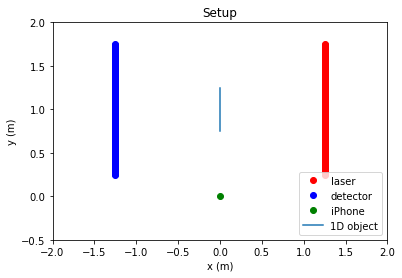

In [4]:
from timeit import default_timer as timer
vis_gt = computeVisibility(las_x, las_y, det_x, det_y, 0, 0.75, 1.25)
start = timer()
observations, hists = generateData(las_x, las_y, det_x, det_y, vis_gt, numBins, 
                                   plotData, plotSetup, usePulse, pctNoise, jitter, pulseWidth, t)
end = timer()
print(end - start)
start = timer()
observ2, hists2 = generateDataFast(las_x, las_y, det_x, det_y, vis_gt, numBins, 
                                   plotData, plotSetup, usePulse, pctNoise, jitter, pulseWidth, t)
end = timer()
print(end-start)

In [5]:
def computeVisibilityFast(las_x, las_y, det_x, det_y, x, y1, y2):
    numPixels = len(det_x)
    numSpots = len(las_x)
    
    det_x = np.tile(np.reshape(det_x, (numPixels, 1)), (1, numSpots))
    det_y = np.tile(np.reshape(det_y, (numPixels, 1)), (1, numSpots))

    las_x = np.tile(np.reshape(las_x, (1, numSpots)), (numPixels, 1))
    las_y = np.tile(np.reshape(las_y, (1, numSpots)), (numPixels, 1))
    
    m = (det_y - las_y) / (det_x - las_x)
    y = m * (x - det_x) + det_y
    
    vis =  1 - ((y >= y1) & (y <= y2))
    return vis 

In [6]:
start = timer()
vis_gt = computeVisibility(las_x, las_y, det_x, det_y, 0, 0.75, 1.25)
end = timer()
print(end - start)
start = timer()
vis_fast = computeVisibilityFast(las_x, las_y, det_x, det_y, 0, 0.75, 1.25)
end = timer()
print(end-start)
print(np.sum(np.abs(vis_gt - vis_fast)))

0.028261874999998327
0.0018181670000032568
0.0


In [7]:
print(vis_gt.shape)

(150, 150)


In [8]:
vis_fast.shape

(150, 150)